# Pneumonia Classification

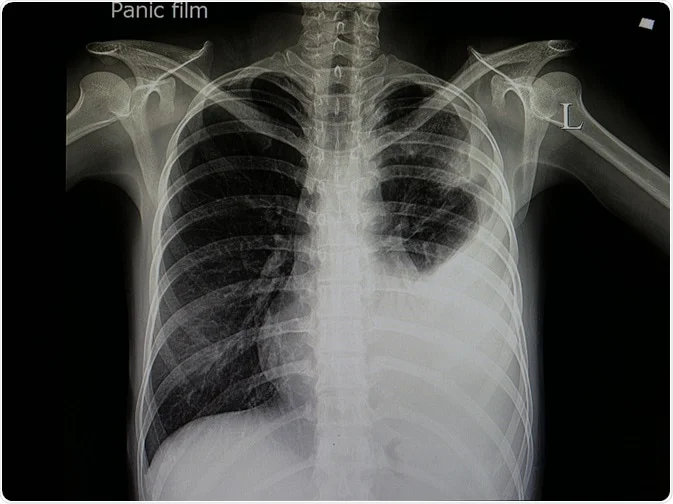

## Overview 
Use neural networks to diagnose pneumonia from chest X-ray images.

## Business Problem

Pneumonia is most common cause of hospital admissions other than women giving birth. The goal of this project is to aid medical professionals with pneumonia diagnosis’  by creating a machine learning algorithm to detect pneumonia from patient’s chest X-rays. The hope is that our algorithm can help reduce error caused by misinterpretation of chest X-rays, streamline the diagnosis process and that is can lighten the workoad of physicians. 

## Data Understanding 
Data was sourced from Kaggle and collected from Guangzhou Women and Children’s Medical Center. It contains a total of 5,856 images that are classified as either “Normal” [0] or “Pneumonia” [1]. The X-ray images are of pediatric patients, ranging from ages 1-5 years, and were preformed as part of the patient's routine clinical care. The images were pre-screened and low-quality/unreadable scans were removed. All images were graded by three different medical professionals. 


In [22]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models 
from keras import layers 
import matplotlib.pyplot as plt
%matplotlib inline
import os
from collections import Counter
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import talos
from keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.optimizers.schedules import ExponentialDecay

In [3]:
train_data_dir = 'chest_xray/train'
val_data_dir = 'chest_xray/val'
test_data_dir = 'chest_xray/test'

In [4]:
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(80,80), batch_size=5216)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(80,80), batch_size=624)
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir, target_size=(80,80), batch_size=16)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Since the images were pre-screened, there is not alot of data cleaning that needs to be done. One thing to check is the class balance between images of normal lungs versus lungs with pneumonia.

In [5]:
train_counter = Counter(train_generator.classes)
print('train:', train_counter)
test_counter = Counter(test_generator.classes)
print('test:', test_counter)

train: Counter({1: 3875, 0: 1341})
test: Counter({1: 390, 0: 234})


Based on the information above, there is a class imbalance in both the train and test datasets. 26% of the images in the train set are of normal lungs while 74% are of pneumonia. There is a similiar imbalance in the test set with 38% of the images being normal and 63% being of pneumonia. This imbalance could affect how the model preforms and could cause it to overpredict the majority class, making more Type I errors. 

In [6]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

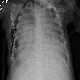

In [7]:
#check to see is images will load properly
array_to_img(train_images[1])

In [8]:
train_labels[1]

array([0., 1.], dtype=float32)

## Data Preparation

Since the labels for an image output as as array of 0 and 1, some reshaping needs to be done so that we can get a single number to label the image. The image data will also need to be reshaped and normalized to be able to work in a dense neural network.

### Image Preprocessing 

In [9]:
print('train:', train_images.shape, train_labels.shape)
print('test:', test_images.shape, test_labels.shape)
print('val:', val_images.shape, val_labels.shape)

train: (5216, 80, 80, 3) (5216, 2)
test: (624, 80, 80, 3) (624, 2)
val: (16, 80, 80, 3) (16, 2)


In [10]:
#reshaping
train_unrow = train_images.reshape(5216,-1)
print('train shape:', train_unrow.shape)

test_unrow = test_images.reshape(624, -1)
print('test shape:', test_unrow.shape)

val_unrow = val_images.reshape(16, -1)
print('validation shape:', val_unrow.shape)

train shape: (5216, 19200)
test shape: (624, 19200)
validation shape: (16, 19200)


In [11]:
#image normalization - converting each pixel value to a value between 0 and 1
train_image_final = train_unrow/255
test_image_final = test_unrow/255
val_image_final = val_unrow/255

### Label Preprocessing 

In [12]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
train_label_final = np.reshape(train_labels[:,1], (5216,1))
print('train shape:', np.shape(train_label_final))

test_label_final = np.reshape(test_labels[:,1], (624,1))
print('test shape:', np.shape(test_label_final))

val_label_final = np.reshape(val_labels[:,1], (16,1))
print('validation shape:', np.shape(val_label_final))

train shape: (5216, 1)
test shape: (624, 1)
validation shape: (16, 1)


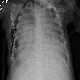

In [15]:
#check
array_to_img(train_images[1])

In [16]:
# value 0 = normal, 1 = pneumonia
train_label_final[1]

array([1.], dtype=float32)

After reformating the labels, we know that the second image in the train set is of pneumonia - because the value of 1. 

## Data Modeling 

**Initial Model: Dense Neural Network**

In [22]:
#stop training when validation accuracy fails to increase after 10 epochs
early_stopping = EarlyStopping(monitor = 'val_acc', patience=10)
callback_list = [early_stopping]

In [23]:
np.random.seed(123)

base_model = models.Sequential()
base_model.add(layers.Dense(2000, activation='relu', input_shape=(12288,)))
base_model.add(layers.Dense(100, activation='relu'))
base_model.add(layers.Dense(1, activation='softmax'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2000)              24578000  
_________________________________________________________________
dense_4 (Dense)              (None, 100)               200100    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 24,778,201
Trainable params: 24,778,201
Non-trainable params: 0
_________________________________________________________________


In [24]:
base_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [26]:
base_results = base_model.fit(train_image_final, train_label_final, epochs=100, callbacks=callback_list,
                              batch_size=64, validation_data=(val_image_final, val_label_final))

Epoch 1/100
82/82 [==============================] - 11s 132ms/step - loss: nan - acc: 0.3863 - val_loss: nan - val_acc: 0.5000
Epoch 2/100
82/82 [==============================] - 11s 139ms/step - loss: nan - acc: 0.2571 - val_loss: nan - val_acc: 0.5000
Epoch 3/100
82/82 [==============================] - 12s 147ms/step - loss: nan - acc: 0.2571 - val_loss: nan - val_acc: 0.5000
Epoch 4/100
82/82 [==============================] - 12s 147ms/step - loss: nan - acc: 0.2571 - val_loss: nan - val_acc: 0.5000
Epoch 5/100
82/82 [==============================] - 11s 139ms/step - loss: nan - acc: 0.2571 - val_loss: nan - val_acc: 0.5000
Epoch 6/100
82/82 [==============================] - 14s 172ms/step - loss: nan - acc: 0.2571 - val_loss: nan - val_acc: 0.5000
Epoch 7/100
82/82 [==============================] - 13s 159ms/step - loss: nan - acc: 0.2571 - val_loss: nan - val_acc: 0.5000
Epoch 8/100
82/82 [==============================] - 11s 138ms/step - loss: nan - acc: 0.2571 - val_loss

In [17]:
#function to visualize model preformance 
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

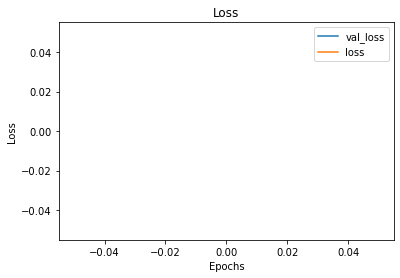

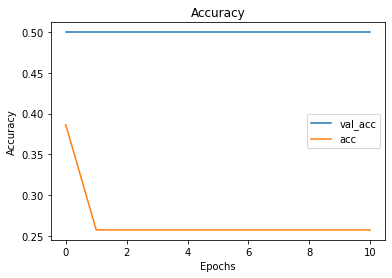

In [28]:
visualize_training_results(base_results)

**Analysis:** With an accuracy score of 26% for the training data and 50% for the validation data, the model has a lot of room for improvement. It seems to not be learning from the data and is predicting the majority class. In the next iteration, we will make a convolutional neural network because they are known to preform better with image data. We will also change the activation function from 'softmax' to 'sigmoid' along with the optimizer to 'adam' rather than 'sgd'. 

**Model #2: CNN**

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [34]:
results_1 = model.fit(train_images,
                    train_label_final,
                    epochs=100,
                    callbacks=callback_list,
                    validation_data=(val_images, val_label_final))

Epoch 1/100
163/163 [==============================] - 25s 155ms/step - loss: 1.9596 - acc: 0.8568 - val_loss: 0.3403 - val_acc: 0.8125
Epoch 2/100
163/163 [==============================] - 23s 139ms/step - loss: 0.1408 - acc: 0.9459 - val_loss: 0.3421 - val_acc: 0.8750
Epoch 3/100
163/163 [==============================] - 25s 153ms/step - loss: 0.0945 - acc: 0.9657 - val_loss: 0.5980 - val_acc: 0.6250
Epoch 4/100
163/163 [==============================] - 24s 147ms/step - loss: 0.0897 - acc: 0.9674 - val_loss: 0.1089 - val_acc: 0.9375
Epoch 5/100
163/163 [==============================] - 22s 134ms/step - loss: 0.0691 - acc: 0.9758 - val_loss: 0.5254 - val_acc: 0.8125
Epoch 6/100
163/163 [==============================] - 25s 153ms/step - loss: 0.0626 - acc: 0.9760 - val_loss: 0.3732 - val_acc: 0.8125
Epoch 7/100
163/163 [==============================] - 25s 154ms/step - loss: 0.0514 - acc: 0.9820 - val_loss: 0.4017 - val_acc: 0.8125
Epoch 8/100
163/163 [===========================

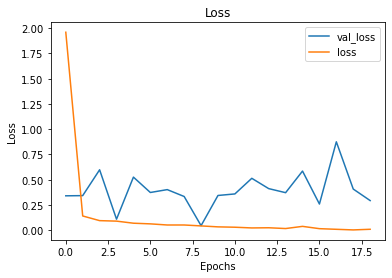

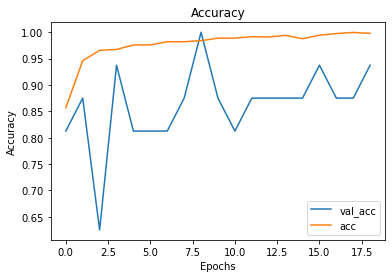

In [35]:
visualize_training_results(results_1)

In [37]:
results_1_train = model.evaluate(train_images, train_label_final)
print('train results:', results_1_train)

results_1_test = model.evaluate(test_images, test_label_final)
print('test results:', results_1_test)

163/163 [==============================] - 6s 35ms/step - loss: 0.0023 - acc: 0.9992
train results: [0.002288704738020897, 0.9992331266403198]
20/20 [==============================] - 1s 32ms/step - loss: 2.1723 - acc: 0.7740
test results: [2.1723170280456543, 0.7740384340286255]


**Analysis:** CNN outpreformed the first model with the testing accuracy of 77% and training accuracy of 99%. Based on the model's preformance, it is overfitting to the training data. To fix this, we will try to slow the rate at which the model is learning and adding additional layers to the model. In the next model, we want to incorperate a pre-trained network - InceptionV3 - which is a popular pre-trained network for image classification. 

**Model #3: InceptionV3**

In [74]:
base_m3 = InceptionV3(input_shape=(80,80,3), include_top=False, weights='imagenet')

In [75]:
#only want to change last layer
for layer in base_m3.layers:
    layer.trainable = False

In [76]:
x = layers.Flatten()(base_m3.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model_3 = keras.models.Model(base_m3.input, x)
model_3.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_473 (Conv2D)             (None, 39, 39, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 39, 39, 32)   96          conv2d_473[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 39, 39, 32)   0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

In [77]:
model_3.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss='binary_crossentropy',
               metrics=['acc'])

In [24]:
early_stopping1 = EarlyStopping(monitor = 'val_loss', patience=10)
callback_list1 = [early_stopping1]

In [81]:
results3 = model_3.fit(train_images, train_label_final, validation_data=(val_images,val_label_final), 
                             callbacks=callback_list1, epochs=100)

Epoch 1/100
163/163 [==============================] - 30s 183ms/step - loss: 0.2285 - acc: 0.9172 - val_loss: 1.5873 - val_acc: 0.7500
Epoch 2/100
163/163 [==============================] - 30s 184ms/step - loss: 0.2142 - acc: 0.9176 - val_loss: 1.2041 - val_acc: 0.6875
Epoch 3/100
163/163 [==============================] - 30s 184ms/step - loss: 0.2177 - acc: 0.9199 - val_loss: 1.3667 - val_acc: 0.6875
Epoch 4/100
163/163 [==============================] - 31s 189ms/step - loss: 0.2273 - acc: 0.9151 - val_loss: 1.3561 - val_acc: 0.6875
Epoch 5/100
163/163 [==============================] - 31s 189ms/step - loss: 0.2236 - acc: 0.9185 - val_loss: 1.8930 - val_acc: 0.6875
Epoch 6/100
163/163 [==============================] - 31s 190ms/step - loss: 0.2072 - acc: 0.9231 - val_loss: 0.9334 - val_acc: 0.6250
Epoch 7/100
163/163 [==============================] - 32s 194ms/step - loss: 0.2026 - acc: 0.9231 - val_loss: 1.5032 - val_acc: 0.6875
Epoch 8/100
163/163 [===========================

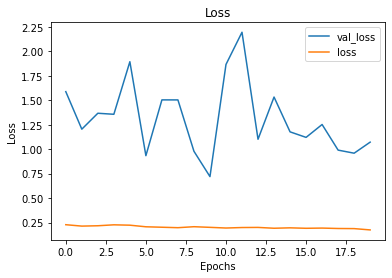

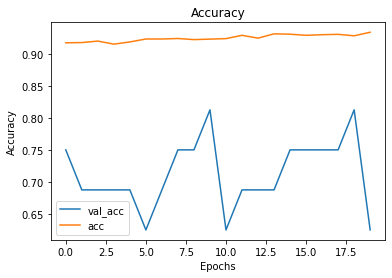

In [82]:
visualize_training_results(results3)

In [86]:
results_3_train = model_3.evaluate(train_images, train_label_final)
print('train results:', results_3_train)

results_3_test = model_3.evaluate(test_images, test_label_final)
print('test results:', results_3_test)

163/163 [==============================] - 30s 184ms/step - loss: 0.1375 - acc: 0.9444
train results: [0.13749095797538757, 0.9444018602371216]
20/20 [==============================] - 3s 171ms/step - loss: 0.8407 - acc: 0.7837
test results: [0.8407375812530518, 0.7836538553237915]


**Analysis:** Using the pre-trained network, InceptionV3, the accuracy improved in the test set from 77% to 78%. In the training set the accuracy decreased from 99% to 94%, which is not too bad when the other metrics are taken into account. For this model, the train and test loss is 0.137 and 0.841 respectively. In the previous model the loss was 0.002 for the train set and 2.17 for the test set. So far, this model is doing better at learning the data and is not overfittting as much to the train data compared to the previous model. We will next try to improve accuracy in this model by changing the hyperparameters.

## Hyperparameter Tuning

To try to increase accuracy of the model, we will adjust the units in the Dropout layer from 0.2 to 0.3. We also will adjust the learning rate of the RMSProp optimizer to show an exponential decay. The hope is that by slowing the learning rate of the model, it will help with the overfitting that is happening which will also help to improve the accuracy. 

In [31]:
base_m4 = InceptionV3(input_shape=(80,80,3), include_top=False, weights='imagenet')

In [32]:
for layer in base_m4.layers:
    layer.trainable = False

In [33]:
x = layers.Flatten()(base_m4.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model_4 = models.Model(base_m4.input, x)
model_4.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 39, 39, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 39, 39, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 39, 39, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [34]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000,
                              decay_rate=0.9)

In [35]:
model_4.compile(optimizer=optimizers.RMSprop(learning_rate=lr_schedule), loss='binary_crossentropy',
               metrics=['acc'])

In [36]:
results4 = model_4.fit(train_images, train_label_final, validation_data=(val_images,val_label_final), epochs=50)

Epoch 1/50
163/163 [==============================] - 33s 205ms/step - loss: 38.9907 - acc: 0.7625 - val_loss: 1.1225 - val_acc: 0.5000
Epoch 2/50
163/163 [==============================] - 37s 229ms/step - loss: 1.6815 - acc: 0.7446 - val_loss: 1.0647 - val_acc: 0.5000
Epoch 3/50
163/163 [==============================] - 32s 199ms/step - loss: 0.9301 - acc: 0.7358 - val_loss: 0.7070 - val_acc: 0.5000
Epoch 4/50
163/163 [==============================] - 33s 200ms/step - loss: 0.6107 - acc: 0.7375 - val_loss: 0.7816 - val_acc: 0.5000
Epoch 5/50
163/163 [==============================] - 34s 209ms/step - loss: 0.9998 - acc: 0.7396 - val_loss: 0.6382 - val_acc: 0.5000
Epoch 6/50
163/163 [==============================] - 30s 187ms/step - loss: 0.5566 - acc: 0.7373 - val_loss: 1.6969 - val_acc: 0.5000
Epoch 7/50
163/163 [==============================] - 32s 198ms/step - loss: 0.4989 - acc: 0.7387 - val_loss: 2.3779 - val_acc: 0.5000
Epoch 8/50
163/163 [==============================] - 

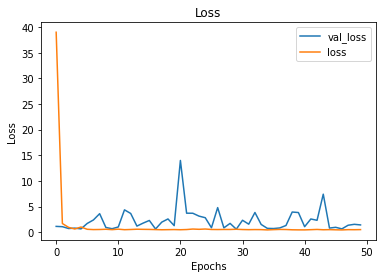

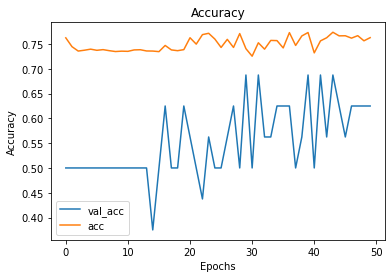

In [37]:
visualize_training_results(results4)

In [38]:
results_4_train = model_4.evaluate(train_images, train_label_final)
print('train results:', results_4_train)

results_4_test = model_4.evaluate(test_images, test_label_final)
print('test results:', results_4_test)

163/163 [==============================] - 30s 186ms/step - loss: 0.3659 - acc: 0.7588
train results: [0.36590713262557983, 0.758819043636322]
20/20 [==============================] - 3s 170ms/step - loss: 1.0479 - acc: 0.7612
test results: [1.047919511795044, 0.7612179517745972]


**Analysis:** Looking at the metrics of this model, the train set recieved an accuracy score of 75.9% and has a loss of 0.370. The test set had an accuracy of 76.1% with a loss of 1.05. Comparing this model to the last model the training accuracy dropped significantly from 94.4% to 75.9%. The test accuracy dropped by 1% between models. Adjusting the learning rate helped with the overfitting that was happening in the previous model. Arguably, the learning rate could be too slow, so this can be adjusted in the next iteration. Also increasing the number of epochs to 200 would most likely give us a higher accuracy. Other optimizer parameters - like momentum - could be adjusted to speed learning rate. 

## Conclusion

Currently, our best preforming model is able to predict pneumonia from a patient's chest X-ray image with 78% accuracy. 

## Next Steps 

Given more time, the goal is to raise the accuracy score even higher. We belive we can accomplish this by tweaking the learning rate even more to try and find the optimal rate. Increase the number of epochs will also allow higher preformance of our model. To adjust other hyperameters and find the best parameters, we can also consider running a gridsearch. 